# **HackBio Bioinformatics Internship - Drug Discovery **

In this Jupyter notebook, we will be building a real-life **data science project**
Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

## **Section 1**
### **ChEMBL Database**

#### Install necessary libraries

In [1]:
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.8 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176717 sha256=15159ab2497582f804fa06fa316836eb34f5bf5b82e560d789a04dd761bac199
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3


### Import libraries

In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import rdkit
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors


### **Target protein search**

Our target **Epidermal growth factor receptor (EGFR)** is from **homo sapiens**, **single protein** and has more  than **1000 compounds**.

In [3]:
# Target search
my_target = new_client.target
my_target_query = my_target.search('Epidermal growth factor receptor erbB1')
my_targets = pd.DataFrame.from_dict(my_target_query)
my_targets

cross_references      organism  \
0     [{'xref_id': 'P00533', 'xref_name': None, 'xre...  Homo sapiens   
1                                                    []  Homo sapiens   
2     [{'xref_id': 'Q01279', 'xref_name': None, 'xre...  Mus musculus   
3     [{'xref_id': 'P01133', 'xref_name': None, 'xre...  Homo sapiens   
4                                                    []  Homo sapiens   
...                                                 ...           ...   
3310                                                 []  Homo sapiens   
3311                                                 []  Homo sapiens   
3312                                                 []  Homo sapiens   
3313                                                 []  Homo sapiens   
3314                                                 []  Homo sapiens   

                                              pref_name  score  \
0                Epidermal growth factor receptor erbB1   39.0   
1     Protein cereblon/Epidermal growth factor receptor   37.0   
2                Epidermal growth factor receptor erbB1   36.0   
3                           Pro-epidermal growth factor   34.0   
4                                           EGFR/PPP1CA   34.0   
...                                                 ...    ...   
3310                    VHL/Tyrosine-protein kinase Lck    0.0   
3311                    VHL/Tyrosine-protein kinase Yes    0.0   
3312                                            VHL/SRC    0.0   
3313                                     Src/Lck kinase    0.0   
3314       Protein cereblon/Tyrosine-protein kinase SRC    0.0   

      species_group_flag target_chembl_id  \
0                  False        CHEMBL203   
1                  False    CHEMBL4523680   
2                  False       CHEMBL3608   
3                  False       CHEMBL5734   
4                  False    CHEMBL4523747   
...                  ...              ...   
3310               False    CHEMBL4523727   
3311               False    CHEMBL4523728   
3312               False    CHEMBL4523733   
3313               False    CHEMBL4523978   
3314               False    CHEMBL4630728   

                                      target_components  \
0     [{'accession': 'P00533', 'component_descriptio...   
1     [{'accession': 'P00533', 'component_descriptio...   
2     [{'accession': 'Q01279', 'component_descriptio...   
3     [{'accession': 'P01133', 'component_descriptio...   
4     [{'accession': 'P00533', 'component_descriptio...   
...                                                 ...   
3310  [{'accession': 'P06239', 'component_descriptio...   
3311  [{'accession': 'P07947', 'component_descriptio...   
3312  [{'accession': 'P12931', 'component_descriptio...   
3313  [{'accession': 'P12931', 'component_descriptio...   
3314  [{'accession': 'P12931', 'component_descriptio...   

                      target_type   tax_id  
0                  SINGLE PROTEIN   9606.0  
1     PROTEIN-PROTEIN INTERACTION   9606.0  
2                  SINGLE PROTEIN  10090.0  
3                  SINGLE PROTEIN   9606.0  
4     PROTEIN-PROTEIN INTERACTION   9606.0  
...                           ...      ...  
3310  PROTEIN-PROTEIN INTERACTION   9606.0  
3311  PROTEIN-PROTEIN INTERACTION   9606.0  
3312  PROTEIN-PROTEIN INTERACTION   9606.0  
3313            SELECTIVITY GROUP   9606.0  
3314  PROTEIN-PROTEIN INTERACTION   9606.0  

[3315 rows x 9 columns]

### **Select and retrieve bioactivity data for target**

We will assign the first entry (which corresponds to the target protein, *Epidermal growth factor receptor erbB1*) to the ***selected_target*** variable

In [4]:
selected_target = my_targets.target_chembl_id[0]
selected_target

'CHEMBL203'

Here, we will retrieve only bioactivity data for *Epidermal growth factor receptor erbB1* (CHEMBL203) that are reported as pChEMBL values.

In [5]:
activity = new_client.activity
data = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
df = pd.DataFrame.from_dict(data)

In [7]:
df.head(5)

action_type activity_comment  activity_id activity_properties  \
0        None             None        32260                  []   
1        None             None        32263                  []   
2        None             None        32265                  []   
3        None             None        32267                  []   
4        None             None        32270                  []   

  assay_chembl_id                                  assay_description  \
0    CHEMBL674637  Inhibitory activity towards tyrosine phosphory...   
1    CHEMBL621151  Inhibition of autophosphorylation of human epi...   
2    CHEMBL615325  Inhibition of ligand-induced proliferation in ...   
3    CHEMBL674637  Inhibitory activity towards tyrosine phosphory...   
4    CHEMBL621151  Inhibition of autophosphorylation of human epi...   

  assay_type assay_variant_accession assay_variant_mutation bao_endpoint  ...  \
0          B                    None                   None  BAO_0000190  ...   
1          F                    None                   None  BAO_0000190  ...   
2          F                    None                   None  BAO_0000190  ...   
3          B                    None                   None  BAO_0000190  ...   
4          F                    None                   None  BAO_0000190  ...   

  target_organism                        target_pref_name target_tax_id  \
0    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
1    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
2    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
3    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
4    Homo sapiens  Epidermal growth factor receptor erbB1          9606   

  text_value  toid  type units    uo_units upper_value  value  
0       None  None  IC50    uM  UO_0000065        None  0.041  
1       None  None  IC50    uM  UO_0000065        None    0.3  
2       None  None  IC50    uM  UO_0000065        None   7.82  
3       None  None  IC50    uM  UO_0000065        None   0.17  
4       None  None  IC50    uM  UO_0000065        None   0.04  

[5 rows x 46 columns]

## **Handling missing data**
If any compounds has missing value for the **standard_value** and **canonical_smiles** column then drop it.

In [8]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

<ipython-input-8-955aac5800f0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df.canonical_smiles.notna()]


action_type activity_comment  \
0                                                   None             None   
1                                                   None             None   
2                                                   None             None   
3                                                   None             None   
4                                                   None             None   
...                                                  ...              ...   
17281  {'action_type': 'INHIBITOR', 'description': 'N...             None   
17282  {'action_type': 'INHIBITOR', 'description': 'N...             None   
17283  {'action_type': 'INHIBITOR', 'description': 'N...             None   
17284  {'action_type': 'INHIBITOR', 'description': 'N...             None   
17285  {'action_type': 'INHIBITOR', 'description': 'N...             None   

       activity_id                                activity_properties  \
0            32260                                                 []   
1            32263                                                 []   
2            32265                                                 []   
3            32267                                                 []   
4            32270                                                 []   
...            ...                                                ...   
17281     25105762                                                 []   
17282     25105763                                                 []   
17283     25105764                                                 []   
17284     25106404  [{'comments': None, 'relation': '=', 'result_f...   
17285     25109727  [{'comments': None, 'relation': '=', 'result_f...   

      assay_chembl_id                                  assay_description  \
0        CHEMBL674637  Inhibitory activity towards tyrosine phosphory...   
1        CHEMBL621151  Inhibition of autophosphorylation of human epi...   
2        CHEMBL615325  Inhibition of ligand-induced proliferation in ...   
3        CHEMBL674637  Inhibitory activity towards tyrosine phosphory...   
4        CHEMBL621151  Inhibition of autophosphorylation of human epi...   
...               ...                                                ...   
17281   CHEMBL5263207  Inhibition of wild type EGFR (unknown origin) ...   
17282   CHEMBL5263207  Inhibition of wild type EGFR (unknown origin) ...   
17283   CHEMBL5263207  Inhibition of wild type EGFR (unknown origin) ...   
17284   CHEMBL5263429  Inhibition of EGFR (unknown origin) using (Glu...   
17285   CHEMBL5264736  Inhibition of human EGFR L858R mutant (669 to ...   

      assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0              B                    None                   None  BAO_0000190   
1              F                    None                   None  BAO_0000190   
2              F                    None                   None  BAO_0000190   
3              B                    None                   None  BAO_0000190   
4              F                    None                   None  BAO_0000190   
...          ...                     ...                    ...          ...   
17281          B                    None                   None  BAO_0000190   
17282          B                    None                   None  BAO_0000190   
17283          B                    None                   None  BAO_0000190   
17284          B                    None                   None  BAO_0000190   
17285          B                  P00533                  L858R  BAO_0000190   

       ... target_organism                        target_pref_name  \
0      ...    Homo sapiens  Epidermal growth factor receptor erbB1   
1      ...    Homo sapiens  Epidermal growth factor receptor erbB1   
2      ...    Homo sapiens  Epidermal growth factor receptor erbB1   
3      ...    Homo sapiens  Epidermal growth factor receptor erbB1   
4      ...    Homo 

In [9]:
len(df2.canonical_smiles.unique())

9794

In [10]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
# Reset the index of the DataFrame and drop the old index
df2_nr = df2_nr.reset_index(drop=True)

# Display the DataFrame with the reset index
df2_nr

action_type activity_comment  \
0                                                  None             None   
1                                                  None             None   
2                                                  None             None   
3                                                  None             None   
4                                                  None             None   
...                                                 ...              ...   
9789  {'action_type': 'INHIBITOR', 'description': 'N...             None   
9790  {'action_type': 'INHIBITOR', 'description': 'N...             None   
9791  {'action_type': 'INHIBITOR', 'description': 'N...             None   
9792  {'action_type': 'INHIBITOR', 'description': 'N...             None   
9793  {'action_type': 'INHIBITOR', 'description': 'N...             None   

      activity_id activity_properties assay_chembl_id  \
0           32260                  []    CHEMBL674637   
1           32267                  []    CHEMBL674637   
2           32680                  []    CHEMBL677833   
3           32770                  []    CHEMBL674643   
4           32772                  []    CHEMBL674643   
...           ...                 ...             ...   
9789     25105719                  []   CHEMBL5263205   
9790     25105720                  []   CHEMBL5263205   
9791     25105721                  []   CHEMBL5263205   
9792     25105722                  []   CHEMBL5263205   
9793     25105723                  []   CHEMBL5263205   

                                      assay_description assay_type  \
0     Inhibitory activity towards tyrosine phosphory...          B   
1     Inhibitory activity towards tyrosine phosphory...          B   
2     In vitro inhibition of Epidermal growth factor...          B   
3     Inhibitory concentration of EGF dependent auto...          B   
4     Inhibitory concentration of EGF dependent auto...          B   
...                                                 ...        ...   
9789  Inhibition of EGFR L858R/T790M mutant (unknown...          B   
9790  Inhibition of EGFR L858R/T790M mutant (unknown...          B   
9791  Inhibition of EGFR L858R/T790M mutant (unknown...          B   
9792  Inhibition of EGFR L858R/T790M mutant (unknown...          B   
9793  Inhibition of EGFR L858R/T790M mutant (unknown...          B   

     assay_variant_accession assay_variant_mutation bao_endpoint  ...  \
0                       None                   None  BAO_0000190  ...   
1                       None                   None  BAO_0000190  ...   
2                       None                   None  BAO_0000190  ...   
3                       None                   None  BAO_0000190  ...   
4                       None                   None  BAO_0000190  ...   
...                      ...                    ...          ...  ...   
9789                  P00533            L858R,T790M  BAO_0000190  ...   
9790                  P00533            L858R,T790M  BAO_0000190  ...   
9791                  P00533            L858R,T790M  BAO_0000190  ...   
9792                  P00533            L858R,T790M  BAO_0000190  ...   
9793                  P00533            L858R,T790M  BAO_0000190  ...   

     target_organism                        target_pref_name target_tax_id  \
0       Homo sapiens  Epidermal growth factor receptor erbB1          9606   
1       Homo sapiens  Epidermal growth factor receptor erbB1          9606   
2       Homo sapiens  Epidermal growth factor receptor erbB1          9606   
3       Homo sapiens  Epidermal growth factor receptor erbB1          9606   
4       Homo sapiens  Epidermal growth factor receptor erbB1          9606   
...              ...                                     ...           ...   
9789    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
9790    Homo sapiens  Epidermal growth factor receptor erbB1          9606   
9791    Homo sapiens  Epid

## **Data pre-processing of the bioactivity data**

#### **Combine the 3 columns (molecule_chembl_id, canonical_smiles, standard_value) and bioactivity_class into a DataFrame**

In [11]:
#print the entire column title
columns_list = df2_nr.columns.tolist()

print(columns_list)

['action_type', 'activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'document_year', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'standard_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value', 'value']


In [12]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

molecule_chembl_id                                   canonical_smiles  \
0           CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1           CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2          CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3          CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4           CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   
...                 ...                                                ...   
9789      CHEMBL5270334  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4ccn(C)c4c3)n2...   
9790      CHEMBL5271151  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9791      CHEMBL5265870  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9792      CHEMBL5269747  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9793      CHEMBL5286080  C=CC(=O)Nc1cc(Nc2nccc(Nc3ccc4c(ccn4C)c3)n2)c(O...   

     standard_value  
0              41.0  
1             170.0  
2            9300.0  
3          500000.0  
4         3000000.0  
...             ...  
9789            4.1  
9790            0.6  
9791           27.7  
9792            3.2  
9793            8.4  

[9794 rows x 3 columns]

### **Labeling compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**.

In [13]:
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [14]:
df3.head()

molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1        CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2       CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3       CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4        CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   

  standard_value  
0           41.0  
1          170.0  
2         9300.0  
3       500000.0  
4      3000000.0

In [15]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4.head()

molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1        CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2       CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3       CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4        CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   

  standard_value         class  
0           41.0        active  
1          170.0        active  
2         9300.0  intermediate  
3       500000.0      inactive  
4      3000000.0      inactive

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import pandas as pd
import numpy as np

In [17]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        # Check if elem is a valid SMILES string before converting
        if isinstance(elem, str):
            mol=Chem.MolFromSmiles(elem)
            moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [18]:
# Calculate lipinski descriptors
df_lipinski = lipinski(df4.canonical_smiles)

In [19]:
df_lipinski.head()

MW     LogP  NumHDonors  NumHAcceptors
0  383.814  4.45034         3.0            4.0
1  482.903  3.61432         3.0            6.0
2  369.432  4.77200         1.0            6.0
3  283.287  2.31056         2.0            4.0
4  164.160  1.49000         2.0            2.0

In [20]:
df4.head()

molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1        CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2       CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3       CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4        CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   

  standard_value         class  
0           41.0        active  
1          170.0        active  
2         9300.0  intermediate  
3       500000.0      inactive  
4      3000000.0      inactive

In [21]:
df_combined = pd.concat([df4,df_lipinski], axis=1)

In [22]:
df_combined.head()

molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1        CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2       CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3       CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4        CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   

  standard_value         class       MW     LogP  NumHDonors  NumHAcceptors  
0           41.0        active  383.814  4.45034         3.0            4.0  
1          170.0        active  482.903  3.61432         3.0            6.0  
2         9300.0  intermediate  369.432  4.77200         1.0            6.0  
3       500000.0      inactive  283.287  2.31056         2.0            4.0  
4      3000000.0      inactive  164.160  1.49000         2.0            2.0

In [23]:
df_combined.standard_value.describe()

count        9794
unique       2807
top       10000.0
freq          565
Name: standard_value, dtype: object

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [24]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        try: # this will try to convert i to a float
            i = float(i)
        except ValueError: # if i is not a number, set molar to 0
            molar = 0
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', axis = 1)

    return x
#Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [25]:
df_final = pIC50(df_combined)
df_final

molecule_chembl_id                                   canonical_smiles  \
0           CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1           CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2          CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3          CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4           CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   
...                 ...                                                ...   
9789      CHEMBL5270334  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4ccn(C)c4c3)n2...   
9790      CHEMBL5271151  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9791      CHEMBL5265870  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9792      CHEMBL5269747  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9793      CHEMBL5286080  C=CC(=O)Nc1cc(Nc2nccc(Nc3ccc4c(ccn4C)c3)n2)c(O...   

             class       MW     LogP  NumHDonors  NumHAcceptors     pIC50  
0           active  383.814  4.45034         3.0            4.0  7.387216  
1           active  482.903  3.61432         3.0            6.0  6.769551  
2     intermediate  369.432  4.77200         1.0            6.0  5.031517  
3         inactive  283.287  2.31056         2.0            4.0  3.301030  
4         inactive  164.160  1.49000         2.0            2.0  2.522879  
...            ...      ...      ...         ...            ...       ...  
9789        active  591.514  5.10290         3.0            9.0  8.387216  
9790        active  550.505  5.33730         3.0            7.0  9.221849  
9791        active  548.489  5.09130         3.0            7.0  7.557520  
9792        active  578.515  5.09990         3.0            8.0  8.494850  
9793        active  512.618  4.34040         3.0            9.0  8.075721  

[9794 rows x 8 columns]

In [26]:
df_final.pIC50.describe()

count    9794.000000
mean        6.495455
std         1.491483
min         1.259637
25%         5.247572
50%         6.531210
75%         7.540608
max        17.299989
Name: pIC50, dtype: float64

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [27]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

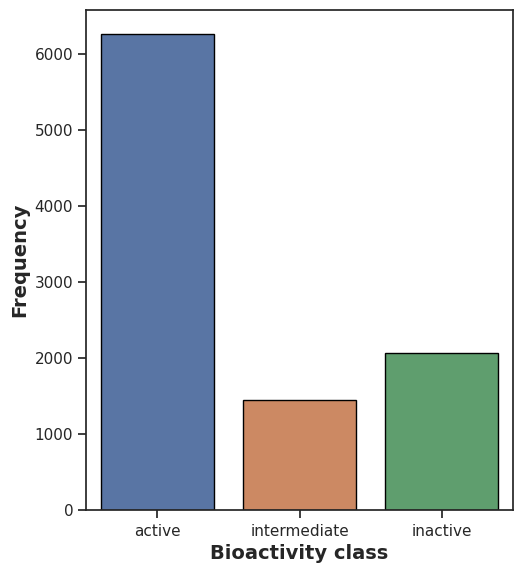

In [28]:
plt.figure(figsize=(5.5, 6.5))

sns.countplot(x='class', data=df_final, edgecolor='black', hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('pfht1_plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

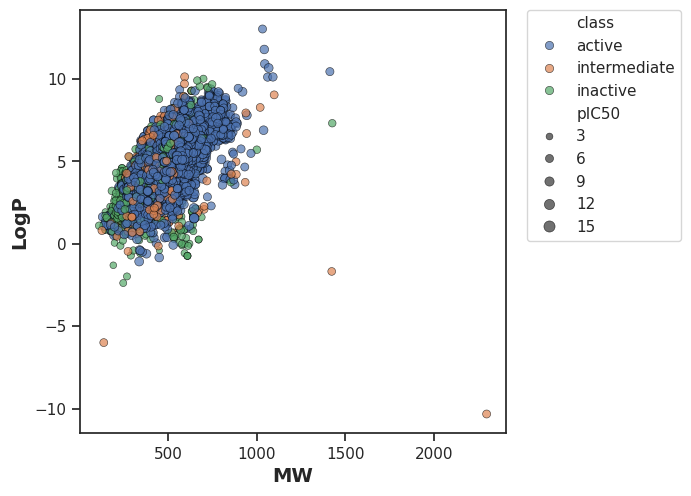

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

In [30]:
df_final

molecule_chembl_id                                   canonical_smiles  \
0           CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1           CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2          CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3          CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4           CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   
...                 ...                                                ...   
9789      CHEMBL5270334  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4ccn(C)c4c3)n2...   
9790      CHEMBL5271151  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9791      CHEMBL5265870  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9792      CHEMBL5269747  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9793      CHEMBL5286080  C=CC(=O)Nc1cc(Nc2nccc(Nc3ccc4c(ccn4C)c3)n2)c(O...   

             class       MW     LogP  NumHDonors  NumHAcceptors     pIC50  
0           active  383.814  4.45034         3.0            4.0  7.387216  
1           active  482.903  3.61432         3.0            6.0  6.769551  
2     intermediate  369.432  4.77200         1.0            6.0  5.031517  
3         inactive  283.287  2.31056         2.0            4.0  3.301030  
4         inactive  164.160  1.49000         2.0            2.0  2.522879  
...            ...      ...      ...         ...            ...       ...  
9789        active  591.514  5.10290         3.0            9.0  8.387216  
9790        active  550.505  5.33730         3.0            7.0  9.221849  
9791        active  548.489  5.09130         3.0            7.0  7.557520  
9792        active  578.515  5.09990         3.0            8.0  8.494850  
9793        active  512.618  4.34040         3.0            9.0  8.075721  

[9794 rows x 8 columns]

In [31]:
#remove NaN
df_cleaned = df_final.dropna()

df_cleaned

molecule_chembl_id                                   canonical_smiles  \
0           CHEMBL68920  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1           CHEMBL69960  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   
2          CHEMBL137635        CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12   
3          CHEMBL306988             CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1   
4           CHEMBL66879                             O=C(O)/C=C/c1ccc(O)cc1   
...                 ...                                                ...   
9789      CHEMBL5270334  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4ccn(C)c4c3)n2...   
9790      CHEMBL5271151  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9791      CHEMBL5265870  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9792      CHEMBL5269747  C=CC(=O)Nc1cc(Nc2ncc(Br)c(Nc3ccc4c(c3)CCC4)n2)...   
9793      CHEMBL5286080  C=CC(=O)Nc1cc(Nc2nccc(Nc3ccc4c(ccn4C)c3)n2)c(O...   

             class       MW     LogP  NumHDonors  NumHAcceptors     pIC50  
0           active  383.814  4.45034         3.0            4.0  7.387216  
1           active  482.903  3.61432         3.0            6.0  6.769551  
2     intermediate  369.432  4.77200         1.0            6.0  5.031517  
3         inactive  283.287  2.31056         2.0            4.0  3.301030  
4         inactive  164.160  1.49000         2.0            2.0  2.522879  
...            ...      ...      ...         ...            ...       ...  
9789        active  591.514  5.10290         3.0            9.0  8.387216  
9790        active  550.505  5.33730         3.0            7.0  9.221849  
9791        active  548.489  5.09130         3.0            7.0  7.557520  
9792        active  578.515  5.09990         3.0            8.0  8.494850  
9793        active  512.618  4.34040         3.0            9.0  8.075721  

[9794 rows x 8 columns]

In [32]:
#subset the pIC50
pIC = df_final[("pIC50")]

In [33]:
# There might be one or more valid SMILES that can represent one compound
# Thanks to Pat Walters for this information,checkout his excellent blog: https://www.blogger.com/profile/18223198920629617711
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

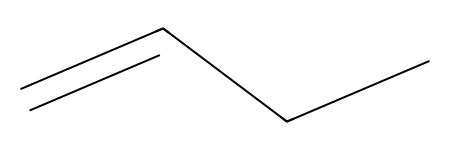

In [34]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('C=CCC')

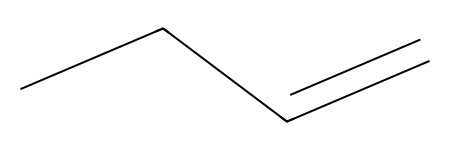

In [35]:
Chem.MolFromSmiles('CCC=C')

## Calculate descriptors using RDkit

### a. General molecular descriptors-about 200 molecular descriptors

In [36]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

In [37]:
# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df_cleaned["canonical_smiles"])

In [38]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          14.205904       -3.279600          14.205904           0.014176   
1          14.386785       -3.932638          14.386785           0.006055   
2           8.794861       -3.421084           8.794861           0.102909   
3          12.518102       -3.895481          12.518102           0.561701   
4          10.996141       -1.465112          10.996141           0.614630   
...              ...             ...                ...                ...   
9789       13.513768       -4.362312          13.513768           0.023706   
9790       13.351285       -4.622305          13.351285           0.018831   
9791       13.352175       -4.237930          13.352175           0.007882   
9792       13.506600       -4.372045          13.506600           0.049422   
9793       13.494407       -4.375225          13.494407           0.097433   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.583357  383.814         368.694  383.094916                  136   
1     0.489619  482.903         462.743  482.126944                  174   
2     0.391062  369.432         350.280  369.170194                  138   
3     0.804599  283.287         270.183  283.095691                  106   
4     0.650834  164.160         156.096  164.047344                   62   
...        ...      ...             ...         ...                  ...   
9789  0.243625  591.514         560.266  590.175334                  202   
9790  0.294177  550.505         518.249  549.185171                  188   
9791  0.354902  548.489         518.249  547.169521                  186   
9792  0.318229  578.515         546.259  577.180085                  198   
9793  0.300016  512.618         480.362  512.264822                  196   

      NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                       0  ...           0             0           0   
1                       0  ...           0             0           0   
2                       0  ...           0             0           0   
3                       0  ...           0             0           0   
4                       0  ...           0             0           0   
...                   ...  ...         ...           ...         ...   
9789                    0  ...           0             0           0   
9790                    0  ...           0             0           0   
9791                    0  ...           0             0           0   
9792                    0  ...           0             0           0   
9793                    0  ...           0             0           0   

      fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                     0             0            0            0             0   
1                     0             0            0            0             0   
2                     0             0            0            0             0   
3                     0             0            0            0             0   
4                     0             0            0            0             0   
...                 ...           ...          ...          ...           ...   
9789                  0             0            0            0             0   
9790                  0             0            0            0             0   
9791                  0             0            0            0             0   
9792                  0             0            0            0             0   
9793                  0             0            0            0             0   

      fr_unbrch_alkane  fr_urea  
0                    0        0  
1                    0        0  
2                    0        0  
3                    0        0  
4                    0        0  
...                ...      ...  
9789                 0        0  
9790                 0        0  
9791        

In [39]:
fp_pIC = pd.concat([df_with_200_descriptors, df_lipinski, pIC], axis=1)

In [40]:
fp_pIC.head()

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       14.205904       -3.279600          14.205904           0.014176   
1       14.386785       -3.932638          14.386785           0.006055   
2        8.794861       -3.421084           8.794861           0.102909   
3       12.518102       -3.895481          12.518102           0.561701   
4       10.996141       -1.465112          10.996141           0.614630   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  0.583357  383.814         368.694  383.094916                  136   
1  0.489619  482.903         462.743  482.126944                  174   
2  0.391062  369.432         350.280  369.170194                  138   
3  0.804599  283.287         270.183  283.095691                  106   
4  0.650834  164.160         156.096  164.047344                   62   

   NumRadicalElectrons  ...  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                    0  ...            0            0             0   
1                    0  ...            0            0             0   
2                    0  ...            0            0             0   
3                    0  ...            0            0             0   
4                    0  ...            0            0             0   

   fr_unbrch_alkane  fr_urea       MW     LogP  NumHDonors  NumHAcceptors  \
0                 0        0  383.814  4.45034         3.0            4.0   
1                 0        0  482.903  3.61432         3.0            6.0   
2                 0        0  369.432  4.77200         1.0            6.0   
3                 0        0  283.287  2.31056         2.0            4.0   
4                 0        0  164.160  1.49000         2.0            2.0   

      pIC50  
0  7.387216  
1  6.769551  
2  5.031517  
3  3.301030  
4  2.522879  

[5 rows x 213 columns]

In [41]:
# the Molecular is now in duplicate, one from Lipinski df (MW) and the other from the molecular descriptor (MolWt), you can drop one
fp_pIC = fp_pIC.drop('MW', axis=1)

In [42]:
fp_pIC

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          14.205904       -3.279600          14.205904           0.014176   
1          14.386785       -3.932638          14.386785           0.006055   
2           8.794861       -3.421084           8.794861           0.102909   
3          12.518102       -3.895481          12.518102           0.561701   
4          10.996141       -1.465112          10.996141           0.614630   
...              ...             ...                ...                ...   
9789       13.513768       -4.362312          13.513768           0.023706   
9790       13.351285       -4.622305          13.351285           0.018831   
9791       13.352175       -4.237930          13.352175           0.007882   
9792       13.506600       -4.372045          13.506600           0.049422   
9793       13.494407       -4.375225          13.494407           0.097433   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.583357  383.814         368.694  383.094916                  136   
1     0.489619  482.903         462.743  482.126944                  174   
2     0.391062  369.432         350.280  369.170194                  138   
3     0.804599  283.287         270.183  283.095691                  106   
4     0.650834  164.160         156.096  164.047344                   62   
...        ...      ...             ...         ...                  ...   
9789  0.243625  591.514         560.266  590.175334                  202   
9790  0.294177  550.505         518.249  549.185171                  188   
9791  0.354902  548.489         518.249  547.169521                  186   
9792  0.318229  578.515         546.259  577.180085                  198   
9793  0.300016  512.618         480.362  512.264822                  196   

      NumRadicalElectrons  ...  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                       0  ...             0            0            0   
1                       0  ...             0            0            0   
2                       0  ...             0            0            0   
3                       0  ...             0            0            0   
4                       0  ...             0            0            0   
...                   ...  ...           ...          ...          ...   
9789                    0  ...             0            0            0   
9790                    0  ...             0            0            0   
9791                    0  ...             0            0            0   
9792                    0  ...             0            0            0   
9793                    0  ...             0            0            0   

      fr_thiophene  fr_unbrch_alkane  fr_urea     LogP  NumHDonors  \
0                0                 0        0  4.45034         3.0   
1                0                 0        0  3.61432         3.0   
2                0                 0        0  4.77200         1.0   
3                0                 0        0  2.31056         2.0   
4                0                 0        0  1.49000         2.0   
...            ...               ...      ...      ...         ...   
9789             0                 0        0  5.10290         3.0   
9790             0                 0        0  5.33730         3.0   
9791             0                 0        0  5.09130         3.0   
9792             0                 0        0  5.09990         3.0   
9793             0                 0        0  4.34040         3.0   

      NumHAcceptors     pIC50  
0               4.0  7.387216  
1               6.0  6.769551  
2               6.0  5.031517  
3               4.0  3.301030  
4               2.0  2.522879  
...             ...       ...  
9789            9.0  8.387216  
9790            7.0  9.221849  
9791            7.0  7.557520  
9792            8.0  8.494850  
9793            9.0  8.075721  

[9794 rows x 212 columns]

In [43]:
# Remove rows with any NaN or missing values from the DataFrame
fp_pIC_cleaned = fp_pIC.dropna()

# Display the cleaned DataFrame
fp_pIC_cleaned

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          14.205904       -3.279600          14.205904           0.014176   
1          14.386785       -3.932638          14.386785           0.006055   
2           8.794861       -3.421084           8.794861           0.102909   
3          12.518102       -3.895481          12.518102           0.561701   
4          10.996141       -1.465112          10.996141           0.614630   
...              ...             ...                ...                ...   
9789       13.513768       -4.362312          13.513768           0.023706   
9790       13.351285       -4.622305          13.351285           0.018831   
9791       13.352175       -4.237930          13.352175           0.007882   
9792       13.506600       -4.372045          13.506600           0.049422   
9793       13.494407       -4.375225          13.494407           0.097433   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.583357  383.814         368.694  383.094916                  136   
1     0.489619  482.903         462.743  482.126944                  174   
2     0.391062  369.432         350.280  369.170194                  138   
3     0.804599  283.287         270.183  283.095691                  106   
4     0.650834  164.160         156.096  164.047344                   62   
...        ...      ...             ...         ...                  ...   
9789  0.243625  591.514         560.266  590.175334                  202   
9790  0.294177  550.505         518.249  549.185171                  188   
9791  0.354902  548.489         518.249  547.169521                  186   
9792  0.318229  578.515         546.259  577.180085                  198   
9793  0.300016  512.618         480.362  512.264822                  196   

      NumRadicalElectrons  ...  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                       0  ...             0            0            0   
1                       0  ...             0            0            0   
2                       0  ...             0            0            0   
3                       0  ...             0            0            0   
4                       0  ...             0            0            0   
...                   ...  ...           ...          ...          ...   
9789                    0  ...             0            0            0   
9790                    0  ...             0            0            0   
9791                    0  ...             0            0            0   
9792                    0  ...             0            0            0   
9793                    0  ...             0            0            0   

      fr_thiophene  fr_unbrch_alkane  fr_urea     LogP  NumHDonors  \
0                0                 0        0  4.45034         3.0   
1                0                 0        0  3.61432         3.0   
2                0                 0        0  4.77200         1.0   
3                0                 0        0  2.31056         2.0   
4                0                 0        0  1.49000         2.0   
...            ...               ...      ...      ...         ...   
9789             0                 0        0  5.10290         3.0   
9790             0                 0        0  5.33730         3.0   
9791             0                 0        0  5.09130         3.0   
9792             0                 0        0  5.09990         3.0   
9793             0                 0        0  4.34040         3.0   

      NumHAcceptors     pIC50  
0               4.0  7.387216  
1               6.0  6.769551  
2               6.0  5.031517  
3               4.0  3.301030  
4               2.0  2.522879  
...             ...       ...  
9789            9.0  8.387216  
9790            7.0  9.221849  
9791            7.0  7.557520  
9792            8.0  8.494850  
9793            9.0  8.075721  

[9781 rows x 212 columns]

In [44]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# dataframe contains 200 descriptor columns and a target column 'pIC50'
X = fp_pIC_cleaned.drop(columns=['pIC50'])  # Features: the 200 descriptors
y = fp_pIC_cleaned['pIC50']  # Target: pIC50 values (or any other target)

# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# feature importance to know which descriptors contribute the most
importances = model.feature_importances_
descriptor_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(descriptor_importances)


Mean Squared Error: 0.8864567958937268
SMR_VSA3                  0.117206
PEOE_VSA3                 0.040758
SMR_VSA7                  0.032501
PEOE_VSA10                0.027051
SlogP_VSA10               0.021219
                            ...   
SMR_VSA8                  0.000000
fr_lactam                 0.000000
fr_isocyan                0.000000
SlogP_VSA9                0.000000
fr_nitro_arom_nonortho    0.000000
Length: 211, dtype: float64


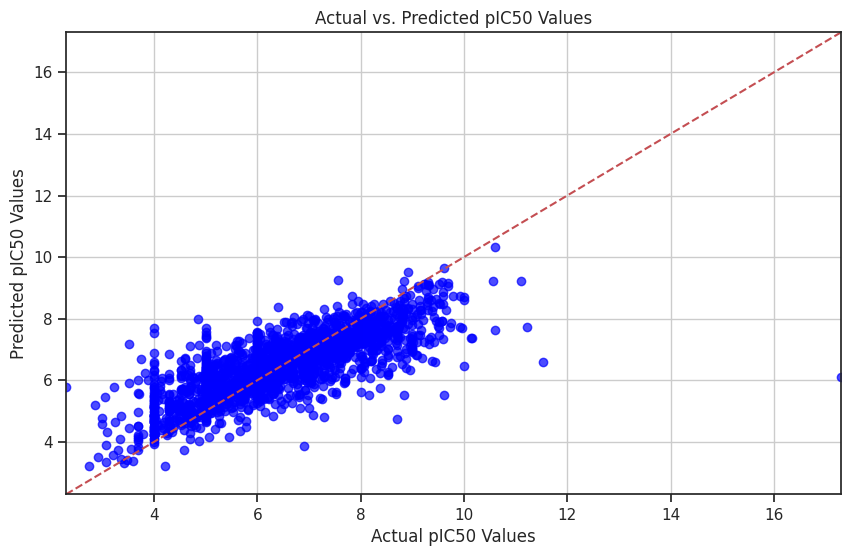

In [48]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of equality
plt.xlabel('Actual pIC50 Values')
plt.ylabel('Predicted pIC50 Values')
plt.title('Actual vs. Predicted pIC50 Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()

In [45]:
descriptor_importances

SMR_VSA3                  0.117206
PEOE_VSA3                 0.040758
SMR_VSA7                  0.032501
PEOE_VSA10                0.027051
SlogP_VSA10               0.021219
                            ...   
SMR_VSA8                  0.000000
fr_lactam                 0.000000
fr_isocyan                0.000000
SlogP_VSA9                0.000000
fr_nitro_arom_nonortho    0.000000
Length: 211, dtype: float64

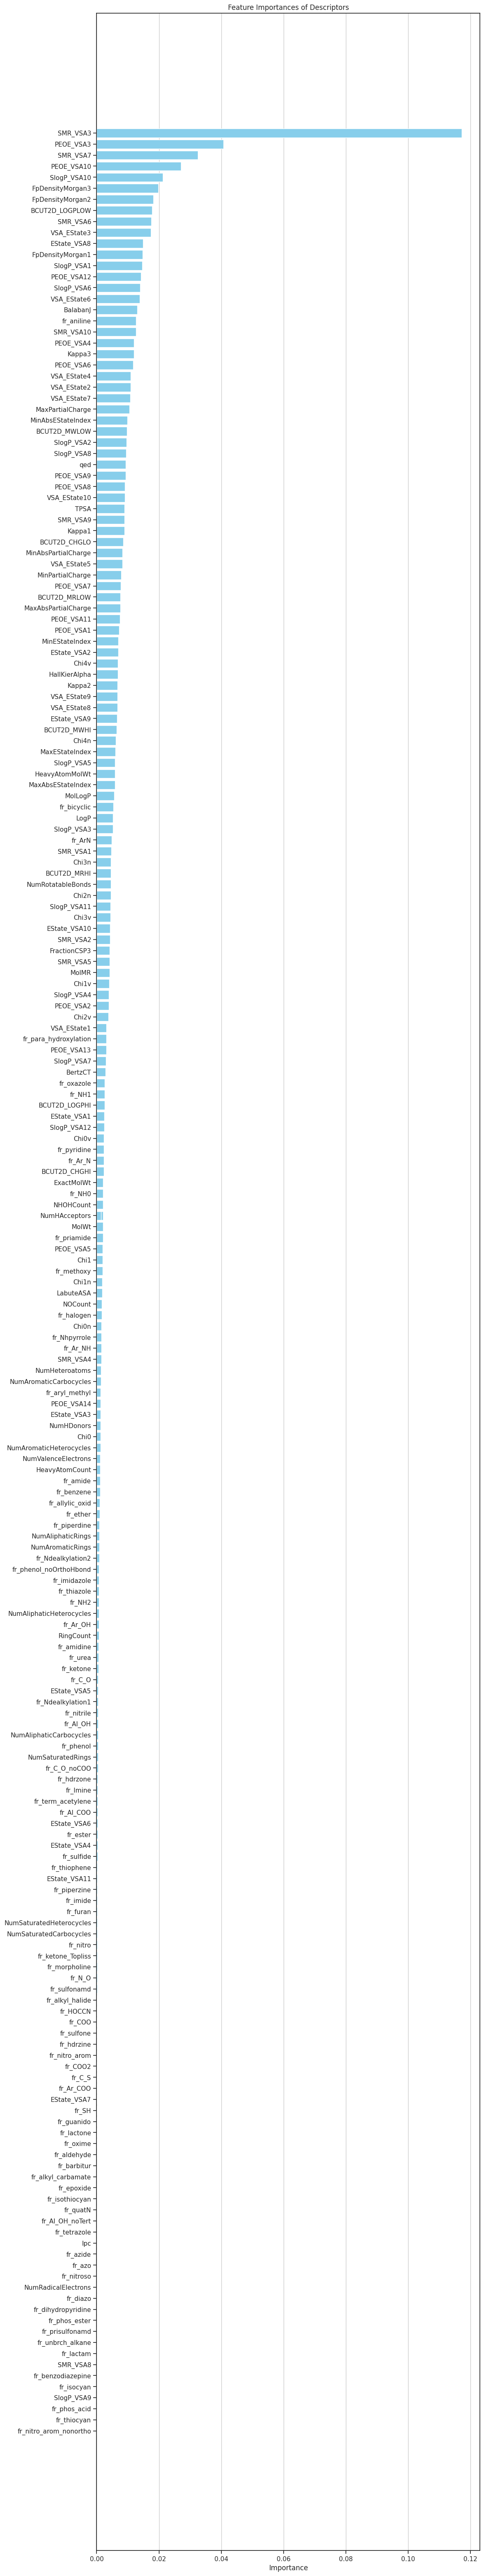

Plot saved as 'descriptor_importances.pdf'.


In [54]:
import matplotlib.pyplot as plt

# Sort the feature importances
sorted_importances = descriptor_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 80))
plt.barh(sorted_importances.index, sorted_importances.values, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances of Descriptors')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.grid(axis='x')
plt.show()

# Save the plot as a PDF
plt.savefig('descriptor_importances.pdf', bbox_inches='tight')  # Save as PDF
plt.close()  # Close the plot to prevent it from displaying in Colab

# Optionally, display a message
print("Plot saved as 'descriptor_importances.pdf'.")

In [46]:
#calculate the r2 score
from sklearn.metrics import r2_score

# Assuming you already have y_test (actual values) and y_pred (predicted values)
r2 = r2_score(y_test, y_pred)

print(f'R² Score: {r2}')

R² Score: 0.6084744098932444


In [47]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Assume df contains your features and target
X = fp_pIC_cleaned.drop(columns=['pIC50'])  # Features
y = fp_pIC_cleaned['pIC50']  # Target variable

# Scale the features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_scores = -cv_scores

# Print the cross-validated MSE scores
print(f'Cross-Validated MSE Scores: {mse_scores}')
print(f'Mean MSE: {mse_scores.mean()}')
print(f'Standard Deviation of MSE: {mse_scores.std()}')

Cross-Validated MSE Scores: [0.89005438 0.74349824 0.71282285 0.76562723 0.7942607 ]
Mean MSE: 0.7812526805006911
Standard Deviation of MSE: 0.060595731456859404


In [55]:
# Save the MSE scores to a DataFrame and then to a CSV file
scores_df = pd.DataFrame({'Fold': range(1, len(mse_scores) + 1), 'MSE': mse_scores})
scores_df.to_csv('cross_validated_mse_scores.csv', index=False)  # Save as CSV

print("MSE scores saved as 'cross_validated_mse_scores.csv'.")

MSE scores saved as 'cross_validated_mse_scores.csv'.
